In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.optimize import minimize

In [77]:
def generate_synthetic_fico_data(n=10000):
    np.random.seed(42)  # For reproducibility
    
    # Simulate Payment History
    # A mix of positive and negative factors
    payment_history = np.random.normal(700, 100, n) - np.random.choice([0, 20, 50, 100], n, p=[0.7, 0.15, 0.1, 0.05])
    
    # Simulate Amounts Owed
    # Influence of credit utilization and total balance
    amounts_owed = 850 - np.random.beta(2, 5, n) * 500  # Beta distribution for utilization skew
    
    # Simulate Length of Credit History
    # Older accounts generally mean higher scores
    length_of_credit_history = np.random.choice(range(300, 850), n, replace=True)
    
    # Simulate Credit Mix
    # More diverse credit types yield higher scores
    credit_mix = np.random.choice(range(600, 850), n, replace=True)
    
    # Simulate New Credit
    # Recent credit activities lower the score
    new_credit = 850 - np.random.gamma(2, 100, n)
    
    # Combine into DataFrame
    data = {
        'Payment History': payment_history,
        'Amounts Owed': amounts_owed,
        'Length of Credit History': length_of_credit_history,
        'Credit Mix': credit_mix,
        'New Credit': new_credit
    }
    df = pd.DataFrame(data)
    
    # Calculate FICO Score with given weights
    weights = {'Payment History': 0.35, 'Amounts Owed': 0.30, 'Length of Credit History': 0.15, 'Credit Mix': 0.10, 'New Credit': 0.10}
    df['FICO Score'] = df.apply(lambda row: sum(row[feature] * weight for feature, weight in weights.items()), axis=1)
    
    return df

# Generate the dataset
fico_df = generate_synthetic_fico_data()


In [78]:
# Sigmoid function to calculate probability
def sigmoid(x):
    return 1 / (1 + np.exp(-0.1 * (x - 650)))

# Calculate the approval probability for each individual
fico_df['Approval Probability'] = sigmoid(fico_df['FICO Score'])

# Assign "true" labels based on approval probability being above a random threshold
# This introduces randomness in the assignment, making some borderline cases get approved or denied
fico_df['True Label'] = (fico_df['Approval Probability'] > np.random.rand(fico_df.shape[0])).astype(int)

In [79]:
fico_df.head(10)

,Payment History,Amounts Owed,Length of Credit History,Credit Mix,New Credit,FICO Score,Approval Probability,True Label
0,749.671415,706.285266,690,670,741.096754,718.880251,0.998981,1
1,686.173570,568.537433,624,685,719.431848,644.765164,0.372038,1
2,764.768854,782.821399,559,609,535.475954,700.813114,0.993827,1
3,852.302986,779.838422,500,609,774.948796,745.652451,0.999930,1
4,676.584663,802.699392,848,638,781.528487,746.767298,0.999937,1
5,676.586304,703.907235,417,664,776.518005,654.579177,0.612520,0
6,857.921282,652.638288,813,712,750.692035,764.283139,0.999989,1
7,756.743473,794.648310,530,657,256.070511,674.061760,0.917297,1
8,653.052561,732.876715,316,843,742.269311,654.358342,0.607266,1
9,734.256004,744.433418,795,636,514.639393,714.633566,0.998443,1


Accuracy: 0.91


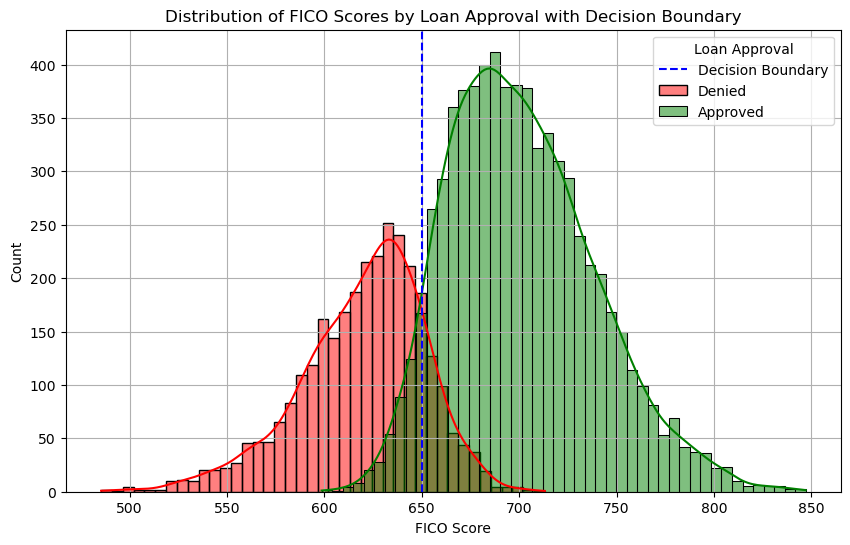

In [118]:
# A classifier that uses the FICO score to predict loan approval
def h(x, beta, threshold):
    return 1 if np.dot(beta, x) >= threshold else 0

weights = {'Payment History': 0.35, 'Amounts Owed': 0.30, 'Length of Credit History': 0.15, 'Credit Mix': 0.10, 'New Credit': 0.10}
beta = np.array([weight for weight in weights.values()])

# Calculate the accuracy of the classifier
fico_df['Predicted Label'] = fico_df.apply(lambda row: h(row[['Payment History', 'Amounts Owed', 'Length of Credit History', 'Credit Mix', 'New Credit']], beta, 650), axis=1)
accuracy = (fico_df['Predicted Label'] == fico_df['True Label']).mean()
print(f'Accuracy: {accuracy:.2f}')

# Plot the distribution of FICO scores for each class and the classifier's decision boundary
plt.figure(figsize=(10, 6))
sns.histplot(fico_df[fico_df['True Label'] == 0]['FICO Score'], color='red', label='Denied', kde=True)
sns.histplot(fico_df[fico_df['True Label'] == 1]['FICO Score'], color='green', label='Approved', kde=True)
plt.axvline(650, color='blue', linestyle='--', label='Decision Boundary')
plt.title('Distribution of FICO Scores by Loan Approval with Decision Boundary')
plt.xlabel('FICO Score')
plt.ylabel('Count')
plt.legend(title='Loan Approval')
plt.grid(True)
plt.show()


In [113]:
# Cost function for changing feature profiles
def c(x, x_0, cost_coefficient=1):
    return cost_coefficient * np.linalg.norm(x - x_0)

# Optimization function to adjust features
def optimize_features(row, weights, threshold=650, cost_coefficient=1, zeta=1):
    x_0 = row[['Payment History', 'Amounts Owed', 'Length of Credit History', 'Credit Mix', 'New Credit']].values
    # bounds = [(0, 100) for _ in range(5)]  # Assuming features are bounded between 0 and 100

    beta = np.array([weight for weight in weights.values()])
    
    def objective(x, beta, x_0, zeta, threshold):
        return -(zeta * h(x, beta, threshold) - c(x, x_0))

    result = minimize(fun=objective, x0=x_0, args=(beta, x_0, zeta, threshold))
    
    return result.x if result.success else x_0

# Initialize a DataFrame to store optimized features
optimized_features_df = fico_df[['Payment History', 'Amounts Owed', 'Length of Credit History', 'Credit Mix', 'New Credit']].copy()

# Optimization for agents with True Label = 0 and Predicted Label = 0
for index, row in fico_df[(fico_df['Predicted Label'] == 0)].iterrows():
    optimized_features = optimize_features(row, weights)
    optimized_features_df.loc[index, ['Payment History', 'Amounts Owed', 'Length of Credit History', 'Credit Mix', 'New Credit']] = optimized_features
    # check if anyone changed
    if (optimized_features != row[['Payment History', 'Amounts Owed', 'Length of Credit History', 'Credit Mix', 'New Credit']].values).any():
        print(f'Optimized features for row {index} (Predicted Label = 0):')
        print(optimized_features)
        print()

# Calculate updated FICO scores using optimized features in `optimized_features_df`
optimized_fico_scores = optimized_features_df.apply(lambda row: sum(row[feature] * weight for feature, weight in weights.items()), axis=1)

# Add the optimized FICO scores to the `optimized_features_df`
optimized_features_df['FICO Score'] = optimized_fico_scores

# Add the 'True Label' from the original `fico_df` to `optimized_features_df` for plotting
optimized_features_df['True Label'] = fico_df['True Label']


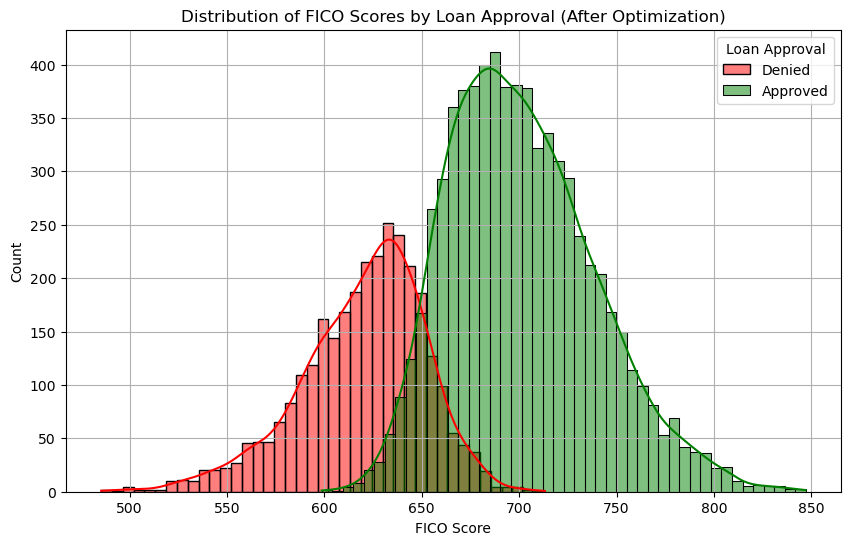

In [114]:
# Plot the distribution of FICO scores for each class after optimization
plt.figure(figsize=(10, 6))
sns.histplot(optimized_features_df[optimized_features_df['True Label'] == 0]['FICO Score'], color='red', label='Denied', kde=True)
sns.histplot(optimized_features_df[optimized_features_df['True Label'] == 1]['FICO Score'], color='green', label='Approved', kde=True)
plt.title('Distribution of FICO Scores by Loan Approval (After Optimization)')
plt.xlabel('FICO Score')
plt.ylabel('Count')
plt.legend(title='Loan Approval')
plt.grid(True)
plt.show()


In [ ]:
'''Do it for one feature'''